# Implementações NSGA

## NSGA-II

In [1]:
import numpy as np
import random

# Algoritmo NSGA
def nsga2(pop_size, generations, bounds, functions):
    # Inicialização da população
    def initialize_population(size, bounds):
        return [random.uniform(bounds[0], bounds[1]) for _ in range(size)]

    # Avaliação
    def evaluate_population(population, functions):
        return [(functions[0](x), functions[1](x)) for x in population]

    # Dominância
    def dominates(obj1, obj2):
        return all(x <= y for x, y in zip(obj1, obj2)) and any(x < y for x, y in zip(obj1, obj2))

    # Ordenação não-dominada (Implementação NSGA-II)
    def fast_nondominated_sort(objectives):
        fronts = [[]]
        domination_count = [0] * len(objectives)
        dominated_solutions = [[] for _ in range(len(objectives))]

        # Identifica a relação de dominância entre todas as soluções
        for p in range(len(objectives)):
            for q in range(len(objectives)):
                if dominates(objectives[p], objectives[q]):
                    dominated_solutions[p].append(q)
                elif dominates(objectives[q], objectives[p]):
                    domination_count[p] += 1

            if domination_count[p] == 0:
                fronts[0].append(p)

        # Construção iterativa das próximas fronteiras
        i = 0
        while len(fronts[i]) > 0:
            next_front = []
            for p in fronts[i]:
                for q in dominated_solutions[p]:
                    domination_count[q] -= 1
                    if domination_count[q] == 0:
                        next_front.append(q)
            i += 1
            fronts.append(next_front)

        fronts.pop()
        return fronts


    # Cruzamento
    def crossover(parent1, parent2):
        return (parent1 + parent2) / 2

    # Mutação
    def mutation(individual, bounds, mutation_rate=0.5):
        if random.random() < mutation_rate:
            individual += random.uniform(-0.1, 0.1)
            individual = np.clip(individual, bounds[0], bounds[1])  # Garante que o valor permaneça nos limites
        return individual
    
    population = initialize_population(pop_size, bounds)

    for gen in range(generations):
        # Avaliação
        objectives = evaluate_population(population, functions)

        # Ordenação não-dominada
        fronts = fast_nondominated_sort(objectives)

        # Visualização no final
        if gen == generations - 1:
            pareto_front = [objectives[i] for i in fronts[0]]
            pareto_front.sort()
            points1 = pareto_front
        
        # Nova geração
        new_population = []
        while len(new_population) < pop_size:
            # Seleção de dois pais
            parent1, parent2 = random.sample(population, 2)

            # Cruzamento
            child = crossover(parent1, parent2)

            # Mutação
            child = mutation(child, bounds)

            new_population.append(child)

        population = population + new_population
    return points1

## NSGA-III

In [2]:
import numpy as np
import random
from collections import defaultdict

# Set random seed for reproducibility
random.seed(42)
np.random.seed(42)

# NSGA-III Algorithm
def nsga3(pop_size, generations, bounds, functions, base_mutation_rate=0.1, divisions=4):
    # Population initialization
    def initialize_population(size, bounds):
        return [random.uniform(bounds[0], bounds[1]) for _ in range(size)]

    # Evaluation
    def evaluate_population(population, functions):
        return [(functions[0](x), functions[1](x)) for x in population]

    # Dominance
    def dominates(obj1, obj2):
        return all(x <= y for x, y in zip(obj1, obj2)) and any(x < y for x, y in zip(obj1, obj2))

    # Non-dominated sorting
    def fast_nondominated_sort(objectives):
        population_size = len(objectives)
        S = [[] for _ in range(population_size)]
        n = [0] * population_size
        rank = [0] * population_size
        fronts = [[]]

        for p in range(population_size):
            for q in range(population_size):
                if dominates(objectives[p], objectives[q]):
                    S[p].append(q)
                elif dominates(objectives[q], objectives[p]):
                    n[p] += 1
            if n[p] == 0:
                rank[p] = 0
                fronts[0].append(p)

        i = 0
        while fronts[i]:
            next_front = []
            for p in fronts[i]:
                for q in S[p]:
                    n[q] -= 1
                    if n[q] == 0:
                        rank[q] = i + 1
                        next_front.append(q)
            i += 1
            fronts.append(next_front)
        fronts.pop()
        return fronts

    # Generate reference points
    def generate_reference_points(M, p):
        def generate_recursive(points, num_objs, left, total, depth, current_point):
            if depth == num_objs - 1:
                current_point.append(left / total)
                points.append(current_point.copy())
                current_point.pop()
            else:
                for i in range(left + 1):
                    current_point.append(i / total)
                    generate_recursive(points, num_objs, left - i, total, depth + 1, current_point)
                    current_point.pop()
        points = []
        generate_recursive(points, M, p, p, 0, [])
        return np.array(points)

    # Environmental selection
    def environmental_selection(population, objectives, fronts, reference_points, pop_size):
        next_population_indices = []
        for front in fronts:
            if len(next_population_indices) + len(front) <= pop_size:
                next_population_indices.extend(front)
            else:
                N = pop_size - len(next_population_indices)
                selected_indices = niching_selection(front, objectives, reference_points, N)
                next_population_indices.extend(selected_indices)
                break
        next_population = [population[i] for i in next_population_indices]
        return next_population

    # Niching selection
    def niching_selection(front, objectives, reference_points, N):
        selected = []
        # Normalize objectives
        objs = np.array([objectives[i] for i in front])
        ideal_point = np.min(objs, axis=0)
        normalized_objs = objs - ideal_point

        # Avoid division by zero
        max_values = np.max(normalized_objs, axis=0)
        max_values[max_values == 0] = 1
        normalized_objs = normalized_objs / max_values

        # Associate each individual with the nearest reference point
        associations = []
        for idx, obj in zip(front, normalized_objs):
            distances = np.linalg.norm(obj - reference_points, axis=1)
            min_index = np.argmin(distances)
            associations.append((idx, min_index, distances[min_index]))

        # Build a dictionary of associations
        reference_associations = defaultdict(list)
        for idx, ref_idx, dist in associations:
            reference_associations[ref_idx].append((idx, dist))

        # Niche counts
        niche_counts = {i: 0 for i in range(len(reference_points))}
        selected_flags = {idx: False for idx in front}

        while len(selected) < N:
            # Find reference points with minimum niche count
            min_niche_count = min(niche_counts.values())
            min_refs = [ref for ref, count in niche_counts.items() if count == min_niche_count]

            for ref_idx in min_refs:
                # Get unselected individuals associated with this reference point
                assoc_inds = reference_associations.get(ref_idx, [])
                unselected_inds = [(idx, dist) for idx, dist in assoc_inds if not selected_flags[idx]]

                if unselected_inds:
                    # Select the individual with the minimum distance
                    unselected_inds.sort(key=lambda x: x[1])
                    selected_idx = unselected_inds[0][0]
                    selected.append(selected_idx)
                    selected_flags[selected_idx] = True
                    niche_counts[ref_idx] += 1
                    break  # Move to the next reference point

            else:
                # If no individuals can be selected, select randomly from unselected individuals
                remaining = [idx for idx in front if not selected_flags[idx]]
                if remaining:
                    selected_idx = random.choice(remaining)
                    selected.append(selected_idx)
                    selected_flags[selected_idx] = True
                else:
                    break  # All individuals have been selected

        return selected[:N]

    # Precompute ranks for tournament selection
    def compute_individual_ranks(fronts):
        individual_ranks = {}
        for rank, front in enumerate(fronts):
            for idx in front:
                individual_ranks[idx] = rank
        return individual_ranks

    # Tournament selection
    def tournament_selection(population, individual_ranks):
        i1, i2 = random.sample(range(len(population)), 2)
        rank1 = individual_ranks[i1]
        rank2 = individual_ranks[i2]
        if rank1 < rank2:
            return population[i1]
        elif rank2 < rank1:
            return population[i2]
        else:
            return population[random.choice([i1, i2])]

    # Crossover
    def crossover(parent1, parent2):
        w = random.uniform(0, 1)
        return w * parent1 + (1 - w) * parent2

    # Mutation
    def mutation(individual, bounds, mutation_rate):
        if random.random() < mutation_rate:
            mutation_amount = random.uniform(-0.1, 0.1)
            individual += mutation_amount
            individual = np.clip(individual, bounds[0], bounds[1])
        return individual
    
    # Initialization
    population = initialize_population(pop_size, bounds)
    M = 2  # Number of objectives
    reference_points = generate_reference_points(M, divisions)

    for gen in range(generations):
        # Evaluate current population
        objectives = evaluate_population(population, functions)
        # Non-dominated sorting
        fronts = fast_nondominated_sort(objectives)
        # Compute individual ranks
        individual_ranks = compute_individual_ranks(fronts)

        # Generate offspring
        offspring_population = []
        while len(offspring_population) < pop_size:
            # Selection
            parent1 = tournament_selection(population, individual_ranks)
            parent2 = tournament_selection(population, individual_ranks)
            # Crossover
            child = crossover(parent1, parent2)
            # Mutation
            mutation_rate = base_mutation_rate * (1 - gen / generations)
            child = mutation(child, bounds, mutation_rate)
            offspring_population.append(child)

        # Combine populations
        combined_population = population + offspring_population
        # Evaluate combined population
        combined_objectives = evaluate_population(combined_population, functions)
        # Non-dominated sorting on combined population
        combined_fronts = fast_nondominated_sort(combined_objectives)
        # Environmental selection
        population = environmental_selection(combined_population, combined_objectives, combined_fronts, reference_points, pop_size)

    # Final evaluation
    objectives = evaluate_population(population, functions)
    fronts = fast_nondominated_sort(objectives)
    pareto_front = [objectives[i] for i in fronts[0]]
    pareto_front.sort()

    return pareto_front

## Função para Plot Comparativa de Soluções

### Plot Resultado e Curva Teórica

In [3]:
import matplotlib.pyplot as plt

def plot(pareto_front, functions, bound, onlycurve=False):
    # Theoretical Pareto curve
    x_theoretical = np.linspace(bound[0], bound[1], 500)
    f1_theoretical = functions[0](x_theoretical)
    f2_theoretical = functions[1](x_theoretical)

    # Plotting the results
    plt.figure(figsize=(10, 6))
    if onlycurve:
        plt.plot(f1_theoretical, f2_theoretical, label="Theoretical Pareto Curve", linestyle='--', color="gray")
    else:
        plt.plot(f1_theoretical, f2_theoretical, label="Theoretical Pareto Curve", color="blue")
    plt.scatter(*zip(*pareto_front), label="NSGA Pareto Front", color="red")
    plt.title("Comparison between Theoretical and NSGA Pareto Fronts")
    plt.xlabel("$f_1(x)$")
    plt.ylabel("$f_2(x)$")
    plt.legend()
    plt.axis("equal")
    plt.grid()
    plt.show()

### Plot comparativo de soluções encontradas

In [4]:
import matplotlib.pyplot as plt

def plot_solutions(points1, points2):
    # Normalizar os valores dos objetivos para [0, 1]
    def normalize(solutions):
        return (solutions - solutions.min(axis=0)) / (solutions.max(axis=0) - solutions.min(axis=0))

    sorted_points1 = sorted(points1, key=lambda point: abs(point[0]))
    sorted_points2 = sorted(points2, key=lambda point: abs(point[0]))
    
    solutions1 = np.array(sorted_points1)
    solutions2 = np.array(sorted_points2)

    normalized_solutions1 = normalize(solutions1)
    normalized_solutions2 = normalize(solutions2)

    # Configuração dos subgráficos
    fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

    # Plot do primeiro conjunto de soluções
    for sol in normalized_solutions1:
        axes[0].plot(np.arange(solutions1.shape[1]), sol, marker='o', alpha=0.7)
    axes[0].set_xticks(np.arange(solutions1.shape[1]))
    axes[0].set_xticklabels([f"Objetivo {i+1}" for i in range(solutions1.shape[1])])
    axes[0].set_xlabel("Objetivos")
    axes[0].set_ylabel("Valores Normalizados")
    axes[0].set_title("Conjunto de Soluções NSGA-II")
    axes[0].grid(alpha=0.3)

    # Plot do segundo conjunto de soluções
    for sol in normalized_solutions2:
        axes[1].plot(np.arange(solutions2.shape[1]), sol, marker='o', alpha=0.7)
    axes[1].set_xticks(np.arange(solutions2.shape[1]))
    axes[1].set_xticklabels([f"Objetivo {i+1}" for i in range(solutions2.shape[1])])
    axes[1].set_xlabel("Objetivos")
    axes[1].set_title("Conjunto de Soluções NSGA-III")
    axes[1].grid(alpha=0.3)

    # Ajustar layout
    plt.tight_layout()
    plt.show()

# Experimentos e Análises

$$
f_1(x)=\sin(x-2)
$$
$$
f_2(x)=\sin(x+2)
$$

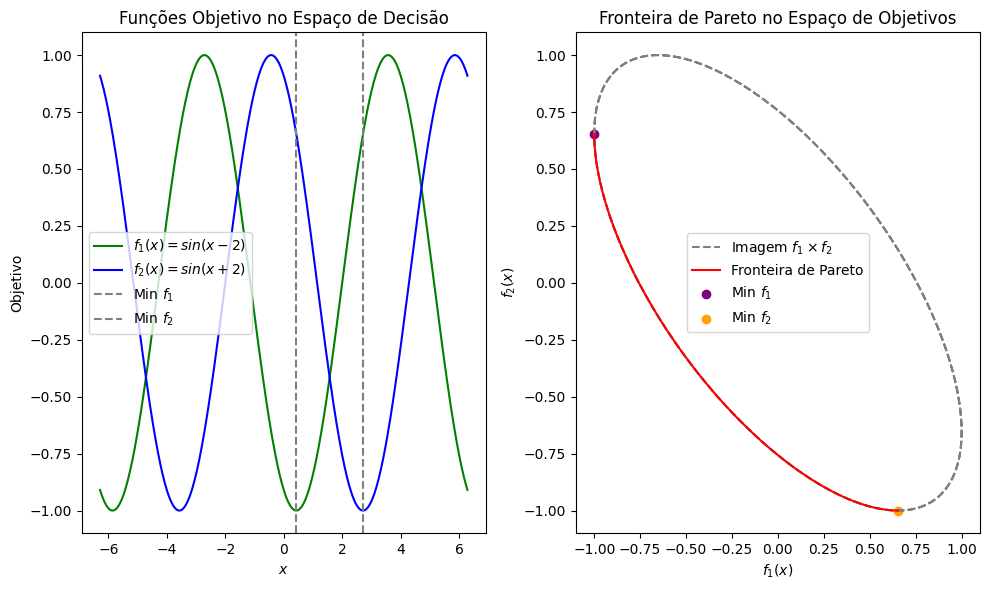

NSGA-II


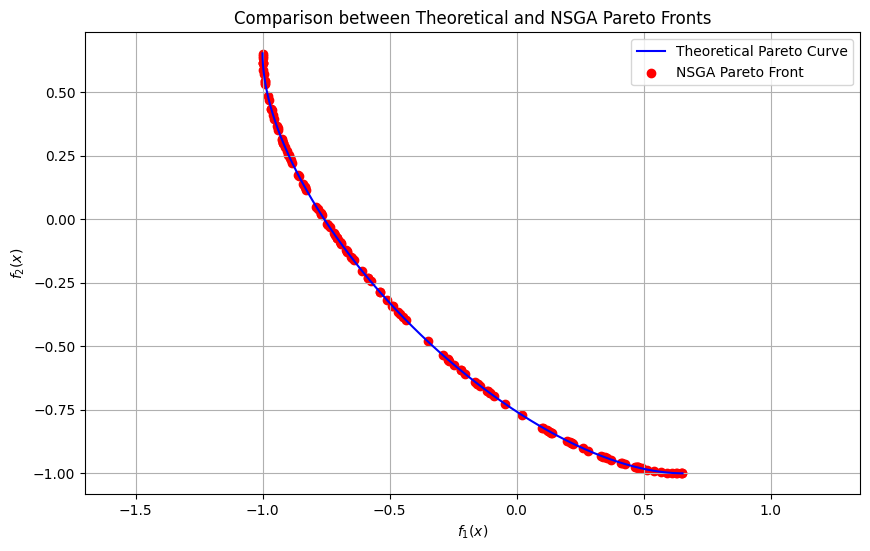

NSGA-III


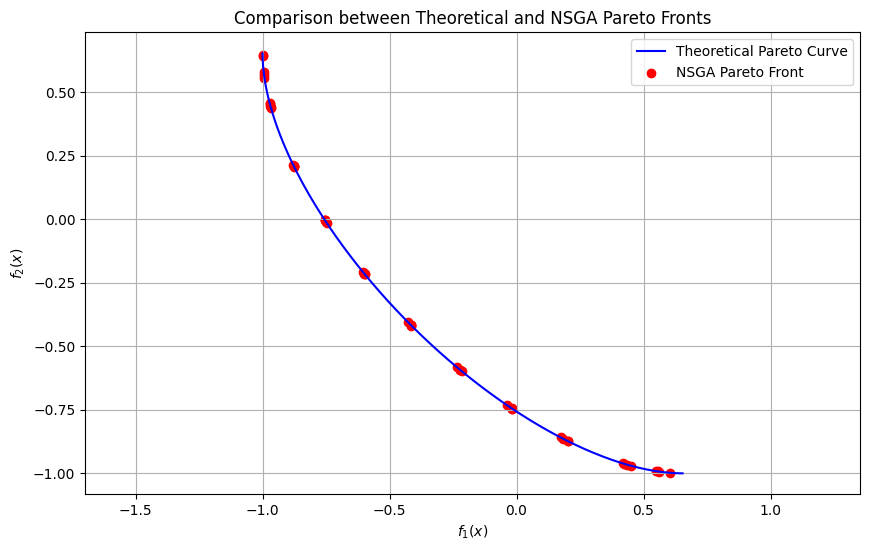

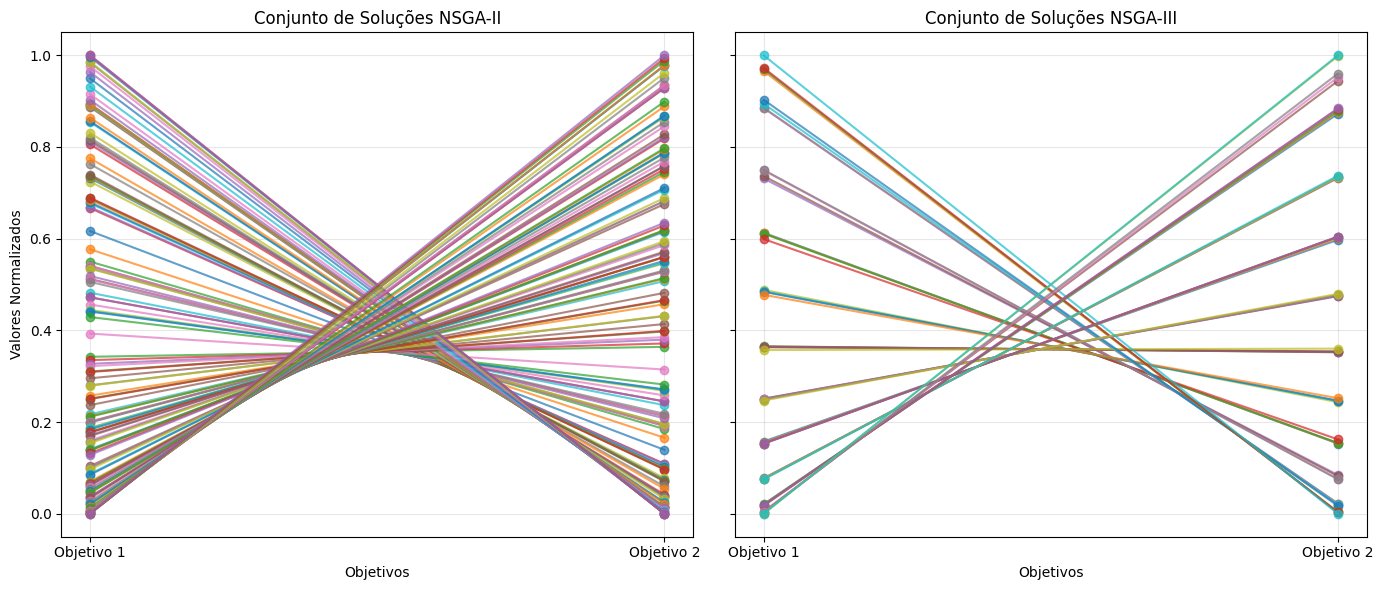

In [5]:
import numpy as np
import matplotlib.pyplot as plt

# Definindo as funções objetivo
def f1(x):
    return np.sin(x-2)

def f2(x):
    return np.sin(x+2)

# Valores de x
x = np.linspace(-2*np.pi, 2*np.pi, 500)
f1_vals = f1(x)
f2_vals = f2(x)

min1 = 2-np.pi/2
min2 = -2-np.pi/2+2*np.pi

y = np.linspace(min1, min2, 500)
pareto_f1_vals = f1(y)
pareto_f2_vals = f2(y)

# Plotando os gráficos
plt.figure(figsize=(10, 6))

# Curva de Pareto no espaço de decisão (x)
plt.subplot(1, 2, 1)
plt.plot(x, f1_vals, label='$f_1(x) = sin(x-2)$', color='green')
plt.plot(x, f2_vals, label='$f_2(x) = sin(x+2)$', color='blue')
plt.axvline(min1, linestyle='--', color='gray', label='Min $f_1$')
plt.axvline(min2, linestyle='--', color='gray', label='Min $f_2$')
plt.title("Funções Objetivo no Espaço de Decisão")
plt.xlabel("$x$")
plt.ylabel("Objetivo")
plt.legend()

# Fronteira de Pareto no espaço de objetivos
plt.subplot(1, 2, 2)
plt.plot(f1_vals, f2_vals, linestyle='--', label='Imagem $f_1\\times f_2$', color='gray')
plt.plot(pareto_f1_vals, pareto_f2_vals, label="Fronteira de Pareto", color='red')
plt.scatter(f1(min1), f2(min1), color='purple', label='Min $f_1$')
plt.scatter(f1(min2), f2(min2), color='orange', label='Min $f_2$')
plt.title("Fronteira de Pareto no Espaço de Objetivos")
plt.xlabel("$f_1(x)$")
plt.ylabel("$f_2(x)$")
plt.legend()

plt.tight_layout()
plt.show()

# Executar NSGA-II
points1 = nsga2(pop_size=50, generations=10, bounds=(-2*np.pi, 2*np.pi), functions=[f1,f2])
print("NSGA-II")
plot(points1, [f1,f2],[min1, min2])

# Run NSGA-III
points2 = nsga3(pop_size=50, generations=10, bounds=(-2*np.pi, 2*np.pi), functions=[f1,f2], divisions=10)
print("NSGA-III")
plot(points2, [f1,f2],[min1,min2])

plot_solutions(points1, points2)

$$
f_1(x)=x\cos(x-2)
$$
$$
f_2(x)=10\sin(x+2)
$$

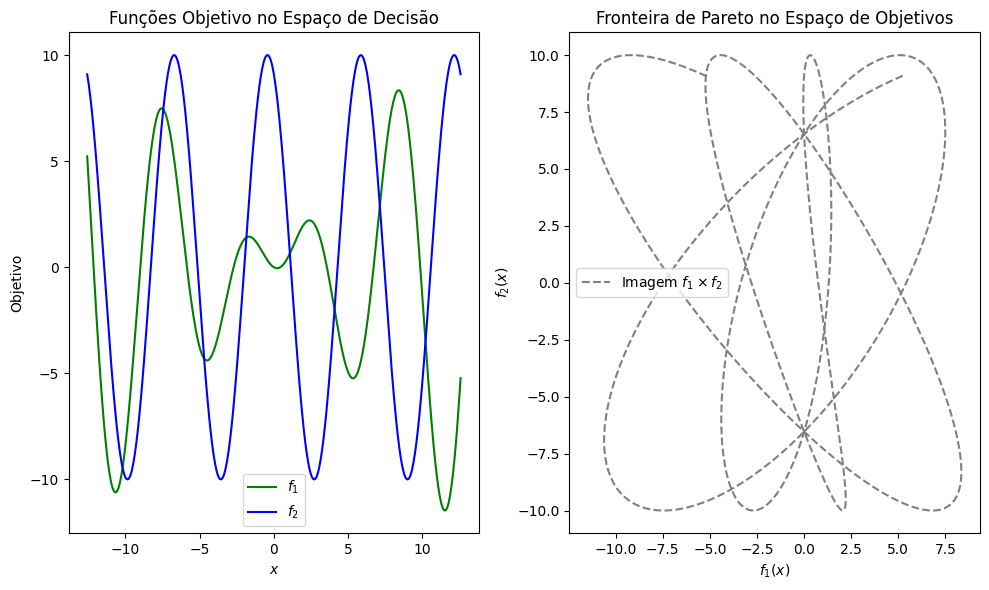

NSGA-II


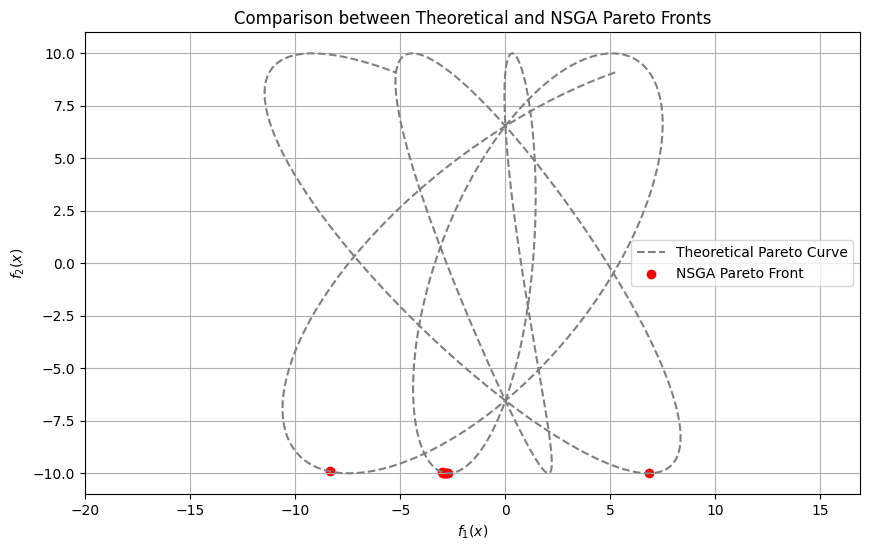

NSGA-III


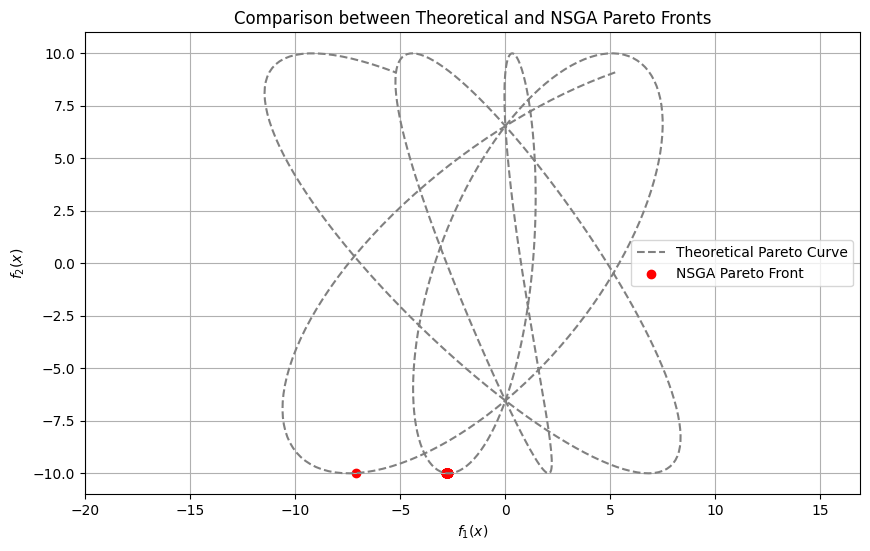

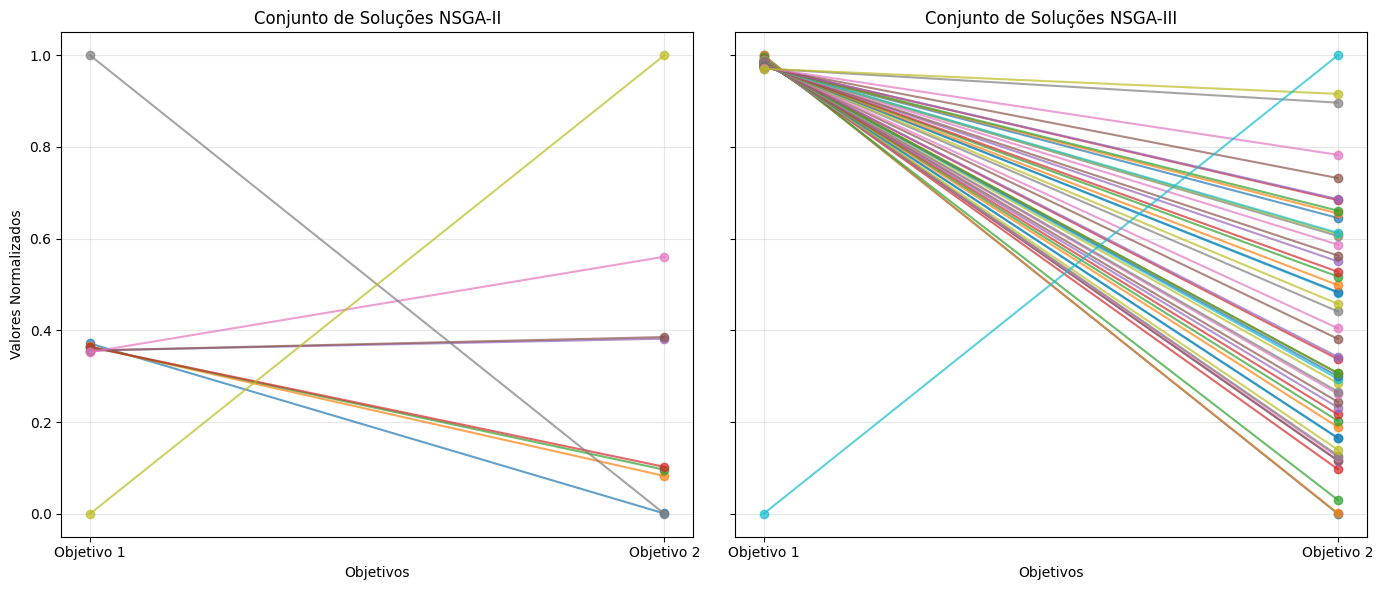

In [11]:
import numpy as np
import matplotlib.pyplot as plt

# Definindo as funções objetivo
def f1(x):
    return x*np.cos(x-2)

def f2(x):
    return 10*np.sin(x+2)

# Valores de x
x = np.linspace(-4*np.pi, 4*np.pi, 500)
f1_vals = f1(x)
f2_vals = f2(x)

y = np.linspace(min1, min2, 500)
pareto_f1_vals = f1(y)
pareto_f2_vals = f2(y)

# Plotando os gráficos
plt.figure(figsize=(10, 6))

# Curva de Pareto no espaço de decisão (x)
plt.subplot(1, 2, 1)
plt.plot(x, f1_vals, label='$f_1$', color='green')
plt.plot(x, f2_vals, label='$f_2$', color='blue')
plt.title("Funções Objetivo no Espaço de Decisão")
plt.xlabel("$x$")
plt.ylabel("Objetivo")
plt.legend()

# Fronteira de Pareto no espaço de objetivos
plt.subplot(1, 2, 2)
plt.plot(f1_vals, f2_vals, linestyle='--', label='Imagem $f_1\\times f_2$', color='gray')
plt.title("Fronteira de Pareto no Espaço de Objetivos")
plt.xlabel("$f_1(x)$")
plt.ylabel("$f_2(x)$")
plt.legend()

plt.tight_layout()
plt.show()

# Executar NSGA-II
points1 = nsga2(pop_size=50, generations=10, bounds=(-10, 10), functions=[f1,f2])
print("NSGA-II")
plot(points1, [f1,f2],[-4*np.pi, 4*np.pi],onlycurve=True)

# Run NSGA-III
points2 = nsga3(pop_size=50, generations=10, bounds=(-10, 10), functions=[f1,f2], divisions=10)
print("NSGA-III")
plot(points2, [f1,f2],[-4*np.pi, 4*np.pi],onlycurve=True)

plot_solutions(points1, points2)

$$
f_1(x)=x^2
$$
$$
f_2(x)=(x-2)^2
$$

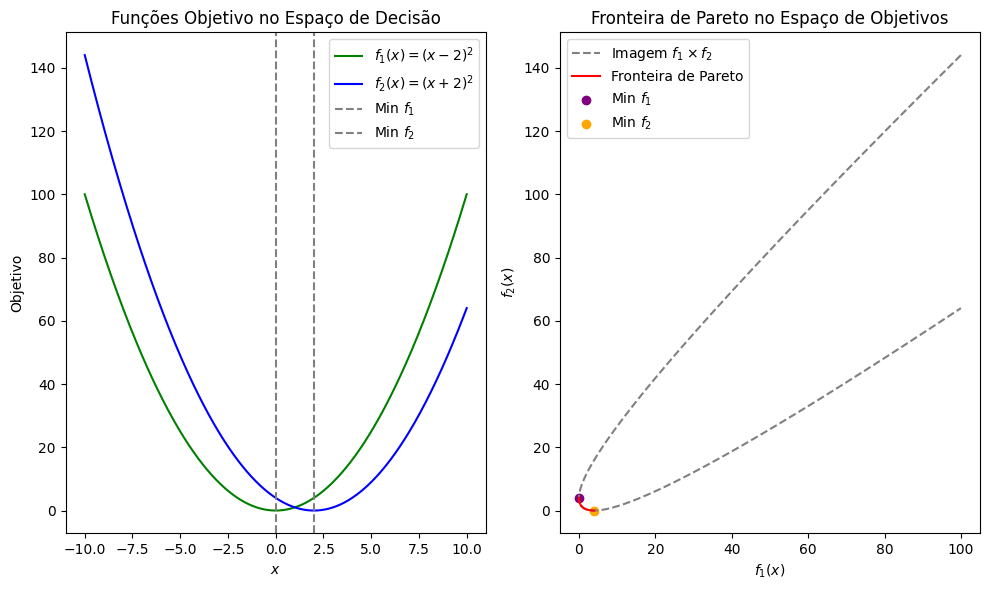

NSGA-II


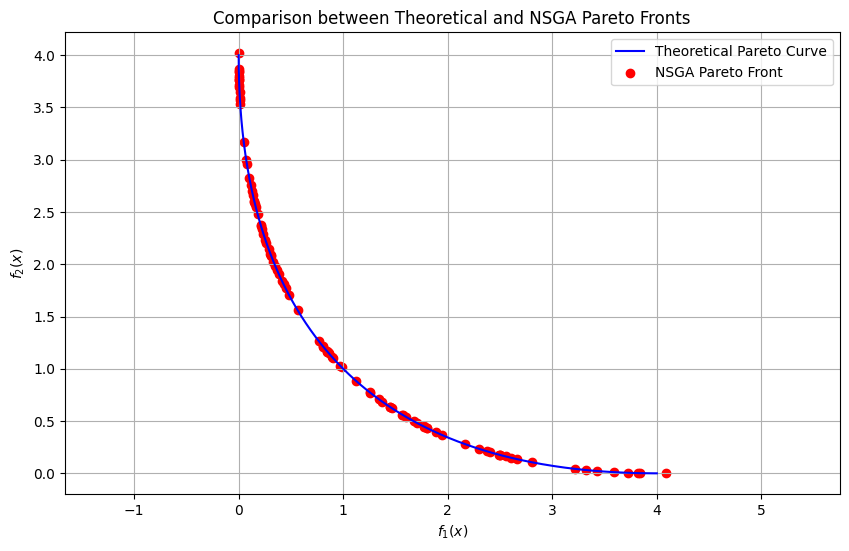

NSGA-III


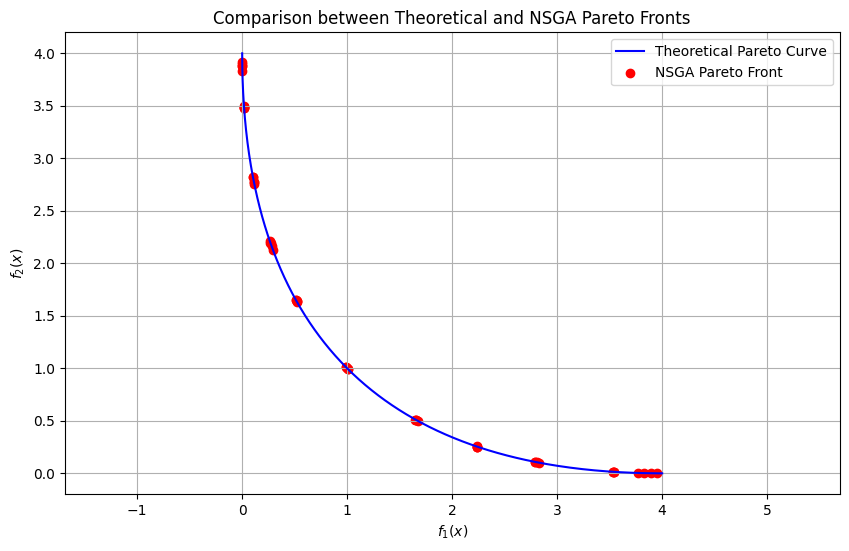

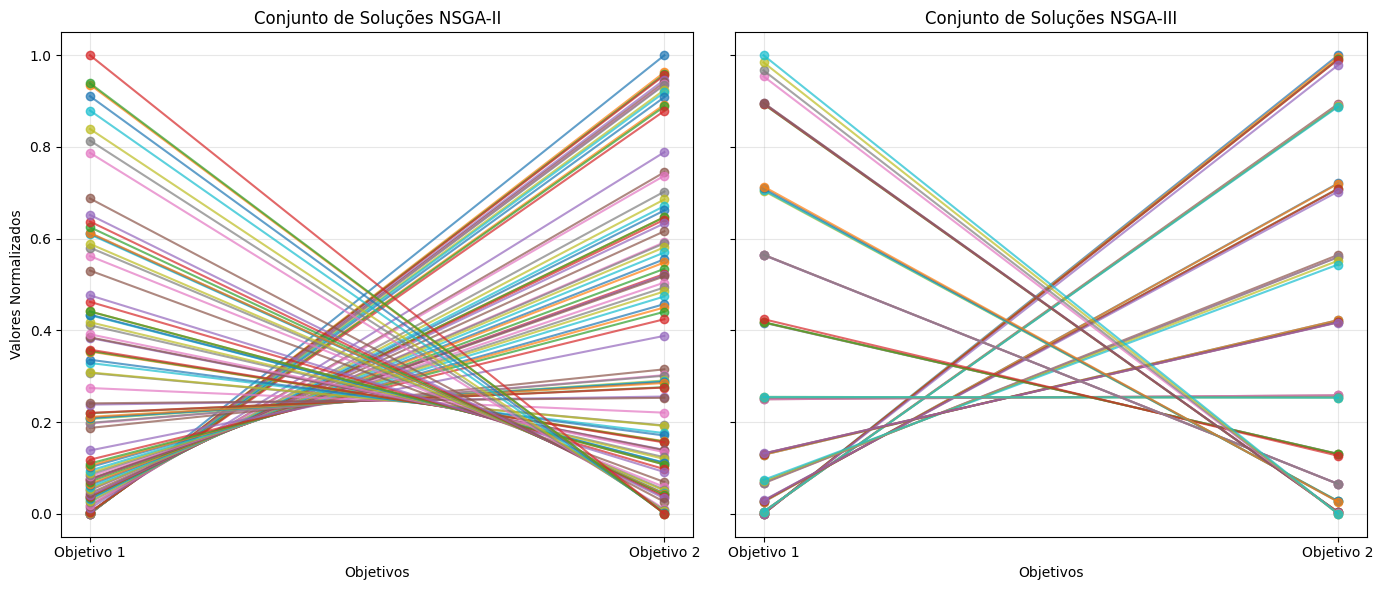

In [7]:
import numpy as np
import matplotlib.pyplot as plt

# Definindo as funções objetivo
def f1(x):
    return x**2

def f2(x):
    return (x-2)**2

# Valores de x
x = np.linspace(-10, 10, 500)
f1_vals = f1(x)
f2_vals = f2(x)

min1 = 0
min2 = 2

y = np.linspace(min1, min2, 500)
pareto_f1_vals = f1(y)
pareto_f2_vals = f2(y)

# Plotando os gráficos
plt.figure(figsize=(10, 6))

# Curva de Pareto no espaço de decisão (x)
plt.subplot(1, 2, 1)
plt.plot(x, f1_vals, label='$f_1(x) = (x-2)^2$', color='green')
plt.plot(x, f2_vals, label='$f_2(x) = (x+2)^2$', color='blue')
plt.axvline(min1, linestyle='--', color='gray', label='Min $f_1$')
plt.axvline(min2, linestyle='--', color='gray', label='Min $f_2$')
plt.title("Funções Objetivo no Espaço de Decisão")
plt.xlabel("$x$")
plt.ylabel("Objetivo")
plt.legend()

# Fronteira de Pareto no espaço de objetivos
plt.subplot(1, 2, 2)
plt.plot(f1_vals, f2_vals, linestyle='--', label='Imagem $f_1\\times f_2$', color='gray')
plt.plot(pareto_f1_vals, pareto_f2_vals, label="Fronteira de Pareto", color='red')
plt.scatter(f1(min1), f2(min1), color='purple', label='Min $f_1$')
plt.scatter(f1(min2), f2(min2), color='orange', label='Min $f_2$')
plt.title("Fronteira de Pareto no Espaço de Objetivos")
plt.xlabel("$f_1(x)$")
plt.ylabel("$f_2(x)$")
plt.legend()

plt.tight_layout()
plt.show()

# Executar NSGA-II
points1 = nsga2(pop_size=50, generations=10, bounds=(-10, 10), functions=[f1,f2])
print("NSGA-II")
plot(points1, [f1,f2],[min1, min2])

# Run NSGA-III
points2 = nsga3(pop_size=50, generations=10, bounds=(-10, 10), functions=[f1,f2], divisions=10)
print("NSGA-III")
plot(points2, [f1,f2],[min1, min2])

plot_solutions(points1, points2)

O exemplo a seguir consideramos a função:
$$
g(x,c_1,c_2,c_3)=-c_1\exp\big(-(x-1)^2\big)-c_2\exp\big(-(x+1)^2\big)+\exp(-3x^2)+c_3 x^2+1
$$
e tomamos o exemplo:
$$
f_1(x)=g(x,1,0.5,0.1)
$$
$$
f_2(x)=g(x,0.5,1,0.1)
$$

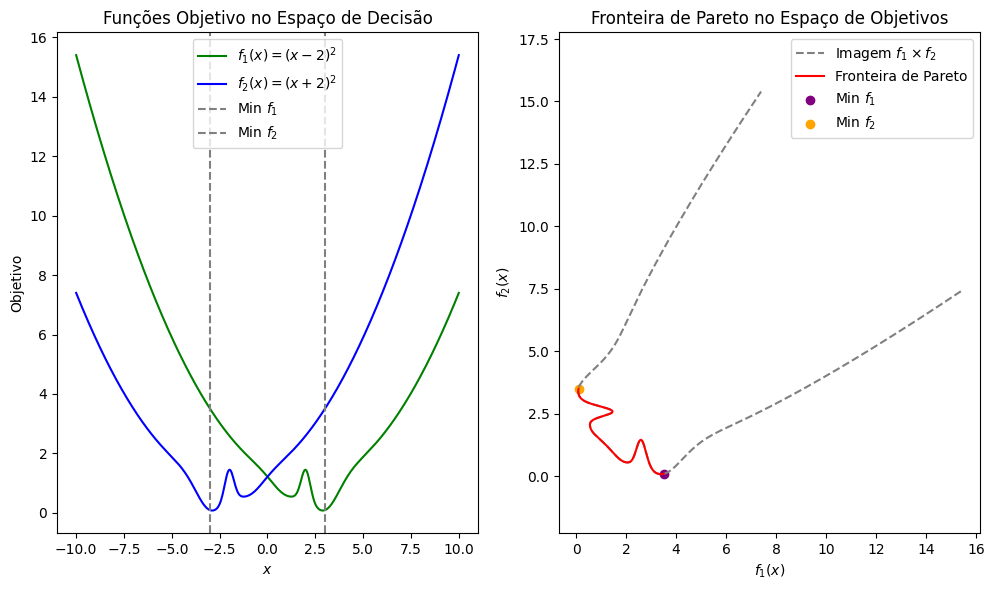

NSGA-II


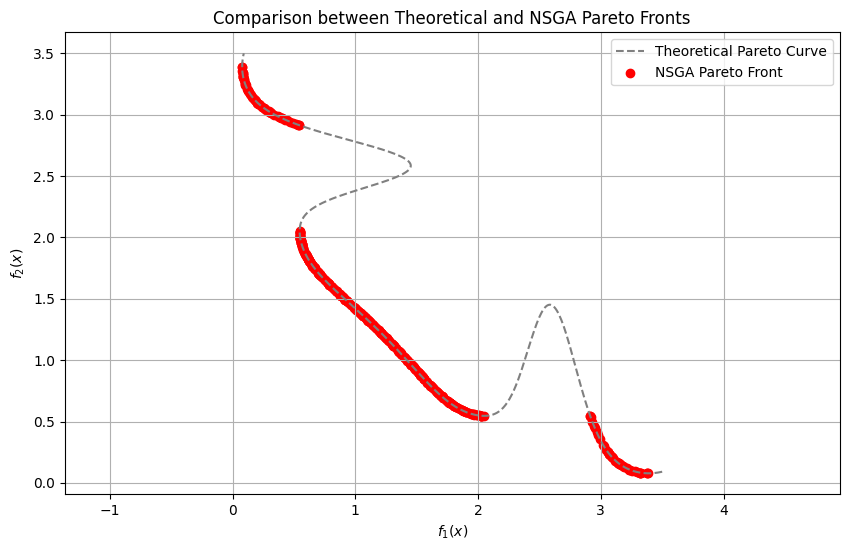

NSGA-III


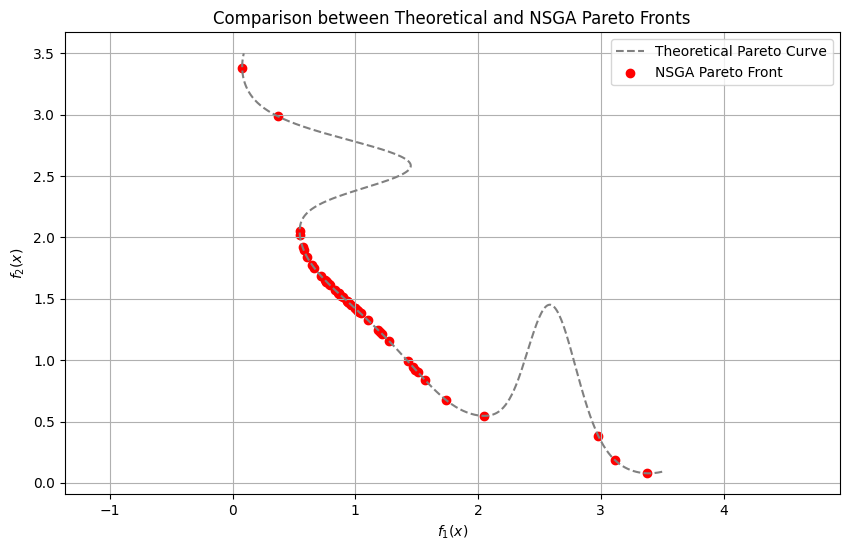

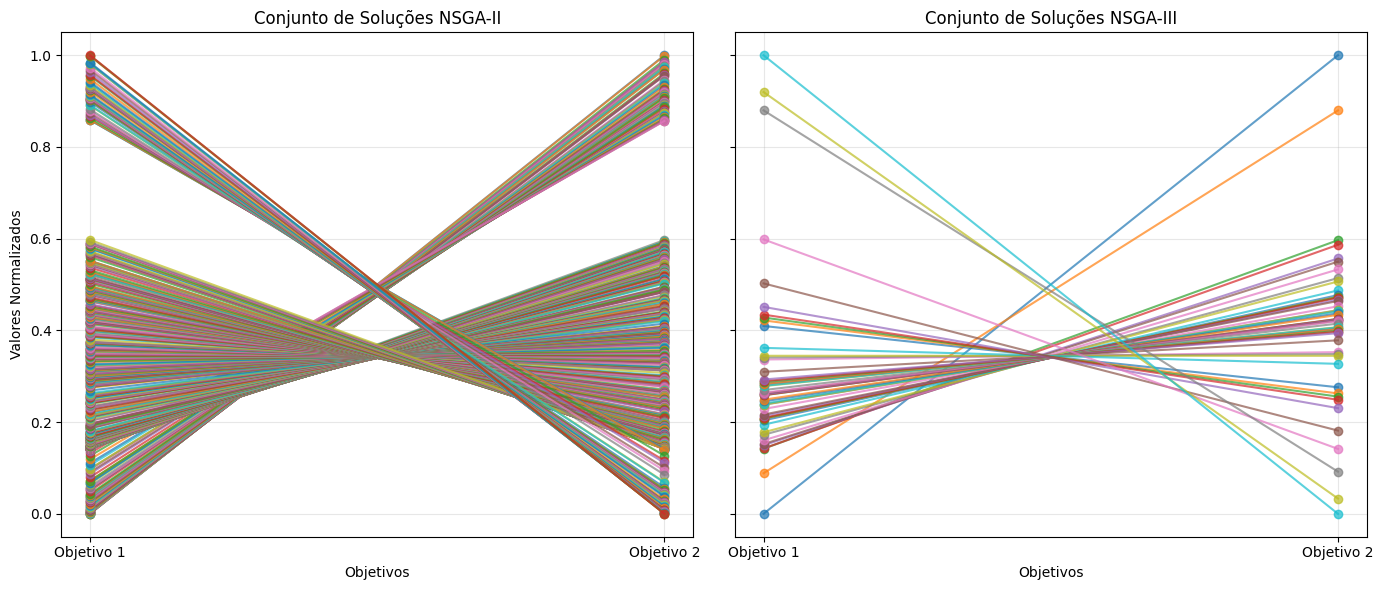

In [8]:
import numpy as np
import matplotlib.pyplot as plt

xi=[1,2,3]

# Definindo as funções objetivo
def f1(x):
    x=x-2
    return -np.exp(-(x-1)**2)-0.5*np.exp(-(x+1)**2)+np.exp(-(3*x)**2)+0.1*x**2+1

def f2(x):
    x=x+2
    return -0.5*np.exp(-(x-1)**2)-np.exp(-(x+1)**2)+np.exp(-(3*x)**2)+0.1*x**2+1

# Valores de x
x = np.linspace(-10, 10, 500)
f1_vals = f1(x)
f2_vals = f2(x)

min1 = -3
min2 = 3

y = np.linspace(min1, min2, 500)
pareto_f1_vals = f1(y)
pareto_f2_vals = f2(y)

# Plotando os gráficos
plt.figure(figsize=(10, 6))

# Curva de Pareto no espaço de decisão (x)
plt.subplot(1, 2, 1)
plt.plot(x, f1_vals, label='$f_1(x) = (x-2)^2$', color='green')
plt.plot(x, f2_vals, label='$f_2(x) = (x+2)^2$', color='blue')
plt.axvline(min1, linestyle='--', color='gray', label='Min $f_1$')
plt.axvline(min2, linestyle='--', color='gray', label='Min $f_2$')
plt.title("Funções Objetivo no Espaço de Decisão")
plt.xlabel("$x$")
plt.ylabel("Objetivo")
plt.legend()

# Fronteira de Pareto no espaço de objetivos
plt.subplot(1, 2, 2)
plt.plot(f1_vals, f2_vals, linestyle='--', label='Imagem $f_1\\times f_2$', color='gray')
plt.plot(pareto_f1_vals, pareto_f2_vals, label="Fronteira de Pareto", color='red')
plt.scatter(f1(min1), f2(min1), color='purple', label='Min $f_1$')
plt.scatter(f1(min2), f2(min2), color='orange', label='Min $f_2$')
plt.title("Fronteira de Pareto no Espaço de Objetivos")
plt.xlabel("$f_1(x)$")
plt.ylabel("$f_2(x)$")
plt.axis('equal')
plt.legend()

plt.tight_layout()
plt.show()

# Executar NSGA-II
points1 = nsga2(pop_size=50, generations=20, bounds=(-10, 10), functions=[f1,f2])
print("NSGA-II")
plot(points1, [f1,f2], [min1, min2], onlycurve=True)

# Run NSGA-III
points2 = nsga3(pop_size=50, generations=30, bounds=(-10, 10), functions=[f1,f2], divisions=10)
print("NSGA-III")
plot(points2, [f1,f2], [min1, min2], onlycurve=True)

plot_solutions(points1, points2)